# Gene Expression Level Analysis Using nanoString Data

In this Jupyter notebook, we are providing the code for the analysis of nanoString data, and we are integrating this data with survival information, our digital marker scores, and immunohistochemistry (IHC) manual annotations for five markers, creating a comprehensive framework for our investigation. By amalgamating these diverse datasets, we aim to uncover intricate relationships between gene expression patterns, survival outcomes, and the presence of specific markers.


## Methods


> **See Also**: For a more in-depth tour about statistical methods you can visit the following papers:
- z-Score: Cheadle C, Vawter MP, Freed WJ, Becker KG. Analysis of Microarray Data Using Z Score Transformation. J Mol Diagn. 2003 May;5(2):73–81
- PCA: Raychaudhuri S, Stuart JM, Altman RB. PRINCIPAL COMPONENTS ANALYSIS TO SUMMARIZE MICROARRAY EXPERIMENTS: APPLICATION TO SPORULATION TIME SERIES. Pac Symp Biocomput. 2000;455–66.
- Spearman correlation: Guo Y, Sheng Q, Li J, Ye F, Samuels DC, Shyr Y. Large Scale Comparison of Gene Expression Levels by Microarrays and RNAseq Using TCGA Data. PLOS ONE. 2013 Aug 20;8(8):e71462
- Bonferroni correction: Armstrong RA. When to use the Bonferroni correction. Ophthalmic and Physiological Optics. 2014;34(5):502–8
- CoxPh: Lin DY, Wei LJ. The Robust Inference for the Cox Proportional Hazards Model. Journal of the American Statistical Association
- GSEA: Subramanian A, Tamayo P, Mootha VK, Mukherjee S, Ebert BL, Gillette MA, et al. Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles. Proceedings of the National Academy of Sciences. 2005 Oct 25;102(43):15545–50


## Data

- For our analysis we used two techniques to fairly apply our methods due to its limitation:
    - Bootstrap resampling
    - k-fold cross-validation

### **python** libraries:
 -lifelines
 -pandas
 -sklearn

In [1]:
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
import pandas as pd
from scipy.stats import zscore
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

Reading the csv files for all the data that we are going to analyze

In [60]:
#clinical information
clinical_info = pd.read_csv("datasets/clinical.csv")
survival_outcomes = pd.read_csv("datasets/survival_outcomes.csv")

#nanoString related data
nanoString_data = pd.read_csv("datasets/nanoString_gene_expression_levels.csv")
nanoString_genes_descriptions = pd.read_csv("datasets/genes_descriptions.csv")
nanoString_pathways = pd.read_csv("datasets/nanoString_pathways_gene_association_original.csv")
nanoString_PAM50 = pd.read_csv("datasets/PAM50.csv")

#Digital scores related data
digital_scores = pd.read_csv("datasets/digi_scores.csv")

#GSEA related data
GSEA_pathways_all = pd.read_csv("datasets/GSEA_all.csv")
GSEA_pathways_Digi_sTILs = pd.read_csv("datasets/GSEA_Digi_sTILs.csv")
GSEA_pathways_Digi_TAS = pd.read_csv("datasets/GSEA_Digi_TAS.csv")

#TMA scores data
TMA_raw_scores = pd.read_csv("datasets/TMA_raw_scores.csv")
TMA_averaged_scores = pd.read_csv("datasets/TMA_scores_av.csv")
TMA_binary = pd.read_csv("datasets/TMA_binary.csv")

To choose the best number of components for PCA using all genes we will apply some determination methods

In [3]:
def pca_variance(dataset, n_components=0.85):
    pca = PCA(n_components=n_components)
    pca_variance_test = pd.DataFrame(data=pca.fit_transform(dataset))
    PCA_cols = []
    for i in range(0, pca.n_components_):
        PCA_cols.append('PCA_' + str(i + 1))

    pca_variance = pd.DataFrame(data=pca.fit_transform(dataset), columns=PCA_cols)

    return pca_variance

In [4]:
# ------------- Scree Plot---------------
def scree_plot(dataset):
    pca = PCA(n_components=20)

    pca.fit_transform(dataset)
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.show()

To cluster the genes to subgroups

In [57]:
def hierarchical_clustering(data):
    # create a linkage matrix
    Z = linkage(data, method='ward', metric='euclidean')
    fig, ax = plt.subplots(figsize=(8, 6), facecolor='none')
    dn = dendrogram(Z)
    #plt.title('Heierarchical Clustering')
    ax.set_title('Heierarchical Clustering')
    plt.savefig('heierarchical.pdf', format='pdf')
    #plt.savefig('heierarchical.png')
    #plt.show()


def k_mean_clustering(data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)

    # Get the cluster assignments for each sample
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Create a scatter plot with no background
    fig, ax = plt.subplots(figsize=(8, 6), facecolor='none')  # Set transparent=True for no background

    # Plot data points with cluster colors
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels)

    # Plot cluster centers
    #ax.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

    # Customize plot
    #ax.set_xlabel('Feature 1')
    #ax.set_ylabel('Feature 2')
    ax.set_title('K-means Clustering')
    #ax.legend()
    #plt.savefig('k_mean.png')
    plt.savefig('kmeans_plot.pdf', format='pdf')
    #plt.show()
    # u_labels = np.unique(labels)
    #
    # # Plot the clusters in 2D
    # plt.scatter(data[:, 0], data[:, 1], c=labels)
    #
    # # plotting the results:
    # for i in u_labels:
    #     # filter rows of original data
    #     filtered_label = data[labels == i]
    #
    #     # Plotting the results
    #     plt.scatter(filtered_label[:, 0], filtered_label[:, 1], label=i)
    #
    #     # plt.scatter(df[labels == i, 0], df[labels == i, 1], label=i)

    # plt.title('K-Means Clustering')
    # plt.savefig('k_mean.png')
    # plt.show()

    return labels

To merge the data from two dataset based on their IDs

In [6]:
def merge_two_datasets(data_one, data_two, ID='ID'):
    all_list = []
    for index, row in data_one.iterrows():
        list_ = []
        for IHC_index, IHC_row in data_two.iterrows():
            if IHC_row[ID] == row[ID]:
                for column, value in row.items():
                    list_.append(value)
                for column_, value_ in IHC_row.items():
                    if not (column_ == ID):
                        list_.append(value_)
                all_list.append(list_)

    first_dataset_cols = data_one.columns.tolist()
    second_dataset_cols = data_two.columns.tolist()
    second_dataset_cols.remove(ID)
    final_cols = first_dataset_cols
    final_cols.extend(second_dataset_cols)

    final_dataset = pd.DataFrame(all_list, columns=final_cols)

    return final_dataset

To perform survival using CoxPh from lifelines

In [7]:
def survival_with_k_folds(data, penalizer=0.0, scoring_method='concordance_index', run_num=10, num_folds=10,
                          print_results=False):
    # Create a Cox Proportional-Hazards model
    cph = CoxPHFitter(penalizer=penalizer)

    # Perform k-fold cross-validation
    results = []
    for _ in range(0, run_num):
        results.extend(k_fold_cross_validation(cph, data, 'time', event_col='event'
                                               , scoring_method=scoring_method, k=num_folds))
    # Print results for each fold
    # for i, result in enumerate(results):
    #     print(f"Fold {i + 1} C-index (concordance index): {result:.3f}")

    # Calculate and print the mean and std for C-index across all folds
    mean_c_index = np.mean(results)
    std_c_index = np.std(results)

    if print_results:
        print(f"\nMean C-index across all folds: {mean_c_index:.3f}")
        print(f"\nSTD C-index across all folds: {std_c_index:.3f}")

    return mean_c_index, std_c_index

Pre-processing the nanoString gene expression levels with z-score and PCA

In [61]:
#remove the IDs
nanoString_data_temp = nanoString_data.drop(['ID'], axis=1)
#apply zscore
nanoString_data_zscore_temp = nanoString_data_temp.apply(zscore)


In [62]:
# --------- PCA Variance  -------------
# we could set the variance to be 85%
nanoString_raw_pca_variance = pca_variance(nanoString_data_temp, n_components=0.85)
# --------- PCA Variance with z-score -------------
nanoString_z_score_pca_variance = pca_variance(nanoString_data_zscore_temp, n_components=0.85)


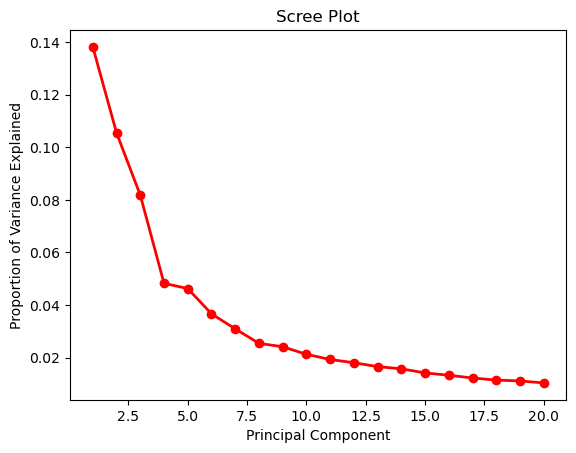

In [63]:
# --------- Scree plot with z_score -------------
pca = PCA(n_components=20)
Principal_components = pca.fit_transform(nanoString_data_temp)

# ------------- Scree Plot---------------
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [64]:
# the scree plot show the best number of PCA components is 5
pca = PCA(n_components=5)
PCA_cols = []
for i in range(0, 5):
    PCA_cols.append('PCA_' + str(i + 1))

nanoString_pca_scree = pd.DataFrame(data=pca.fit_transform(nanoString_data_temp), columns=PCA_cols)
nanoString_z_score_pca_scree = pd.DataFrame(data=pca.fit_transform(nanoString_data_zscore_temp), columns=PCA_cols)


In [65]:
#add IDs back to genes pca, zsocre datasets
nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_data_zscore_temp]
nanoString_data_zscore = pd.concat(nanoString_data_IDs, axis=1, join='inner')

nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_raw_pca_variance]
nanoString_raw_pca_variance = pd.concat(nanoString_data_IDs, axis=1, join='inner')

nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_z_score_pca_variance]
nanoString_z_score_pca_variance = pd.concat(nanoString_data_IDs, axis=1, join='inner')

nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_pca_scree]
nanoString_pca_scree = pd.concat(nanoString_data_IDs, axis=1, join='inner')

nanoString_pca_scree.to_csv('nanoString_pca_scree.txt', sep='\t', index=False)

nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_z_score_pca_scree]
nanoString_z_score_pca_scree = pd.concat(nanoString_data_IDs, axis=1, join='inner')


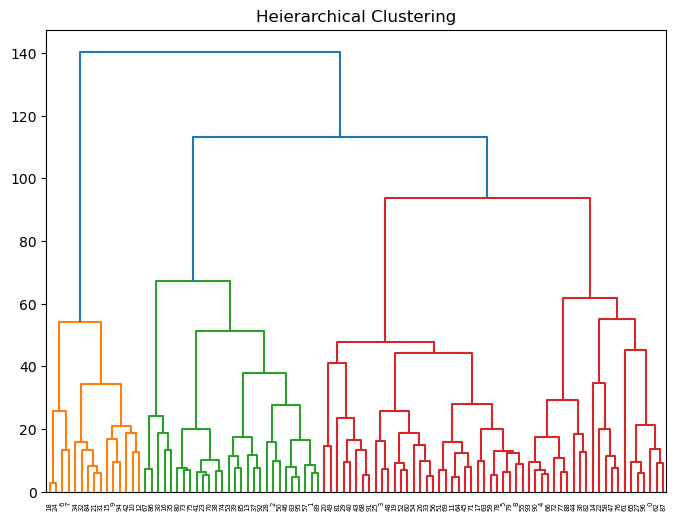

In [58]:
#pefrom clustering on pca scree based dataset
data_temp = nanoString_pca_scree.drop(['ID'], axis=1)
#k_mean_labels = k_mean_clustering(data_temp.to_numpy(), n_clusters=3)

#nanoString_raw_pca_variance_k_mean = data_temp
#nanoString_raw_pca_variance_k_mean['labels'] = k_mean_labels

#nanoString_data_IDs = [nanoString_pca_scree.loc[:, ['ID']], nanoString_raw_pca_variance_k_mean]
#nanoString_raw_pca_variance_k_mean = pd.concat(nanoString_data_IDs, axis=1, join='inner')

#merged_k_mean_data = merge_two_datasets(nanoString_raw_pca_variance_k_mean, TMA_binary, ID='ID')
#merged_k_mean_data.to_csv("/Users/rawan/Desktop/temps.csv");
hierarchical_clustering(data_temp)

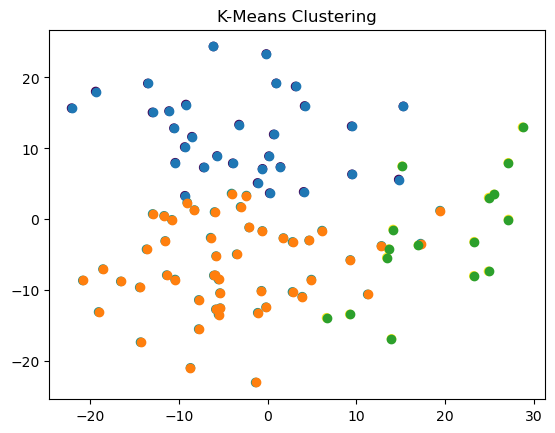

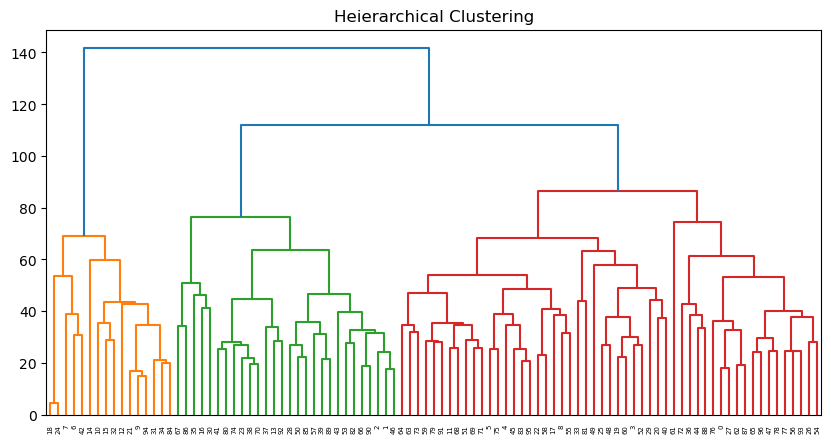

In [25]:
#pefrom clustering on pca variance based dataset
data_temp = nanoString_raw_pca_variance.drop(['ID'], axis=1)
k_mean_clustering(data_temp.to_numpy(), n_clusters=3)
hierarchical_clustering(data_temp, cluster_number=3)

In [66]:
# select the genes that we have their IHC manual scores
columns_nanoString = ['ID', 'AR', 'CLDN3', 'EGFR', 'KRT14', 'KRT5', 'CDH1']
nanoString_data_IHC = nanoString_data[columns_nanoString]

IHC_manual_annotation_nanoString_related_genes = merge_two_datasets(nanoString_data_IHC, TMA_averaged_scores)

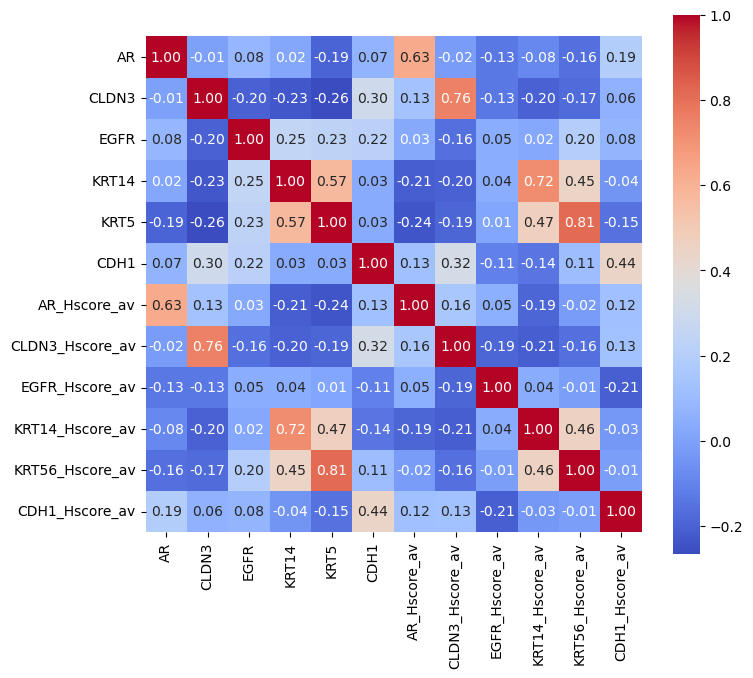

In [76]:
# Calculate Spearman correlation matrix
corr_matrix = IHC_manual_annotation_nanoString_related_genes.corr(method='spearman')

# Create a mask for the upper triangle
#mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap with only the lower triangular part
#plt.figure(figsize=(8, 10))
fig, ax = plt.subplots(figsize=(8, 6), facecolor='none')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)  #, mask=mask)
#ax.title('Spearman Correlation (IHC Manual Scores with nanoString Expression Levels)')
plt.savefig('plots/IHC_nanoString_Spearman.png')
plt.savefig('plots/IHC_nanoString_Spearman.pdf', format='pdf')
#plt.show()

In [77]:
# perform the merge with binary classification IHC based for all the IHC genes
IHC_binary_annotation_nanoString_related_genes = merge_two_datasets(nanoString_data_IHC, TMA_binary)
print(
    f"\nThe number of samples with IHC scores and nanoString data: {len(IHC_binary_annotation_nanoString_related_genes):.0f}")


The number of samples with IHC scores and nanoString data: 84


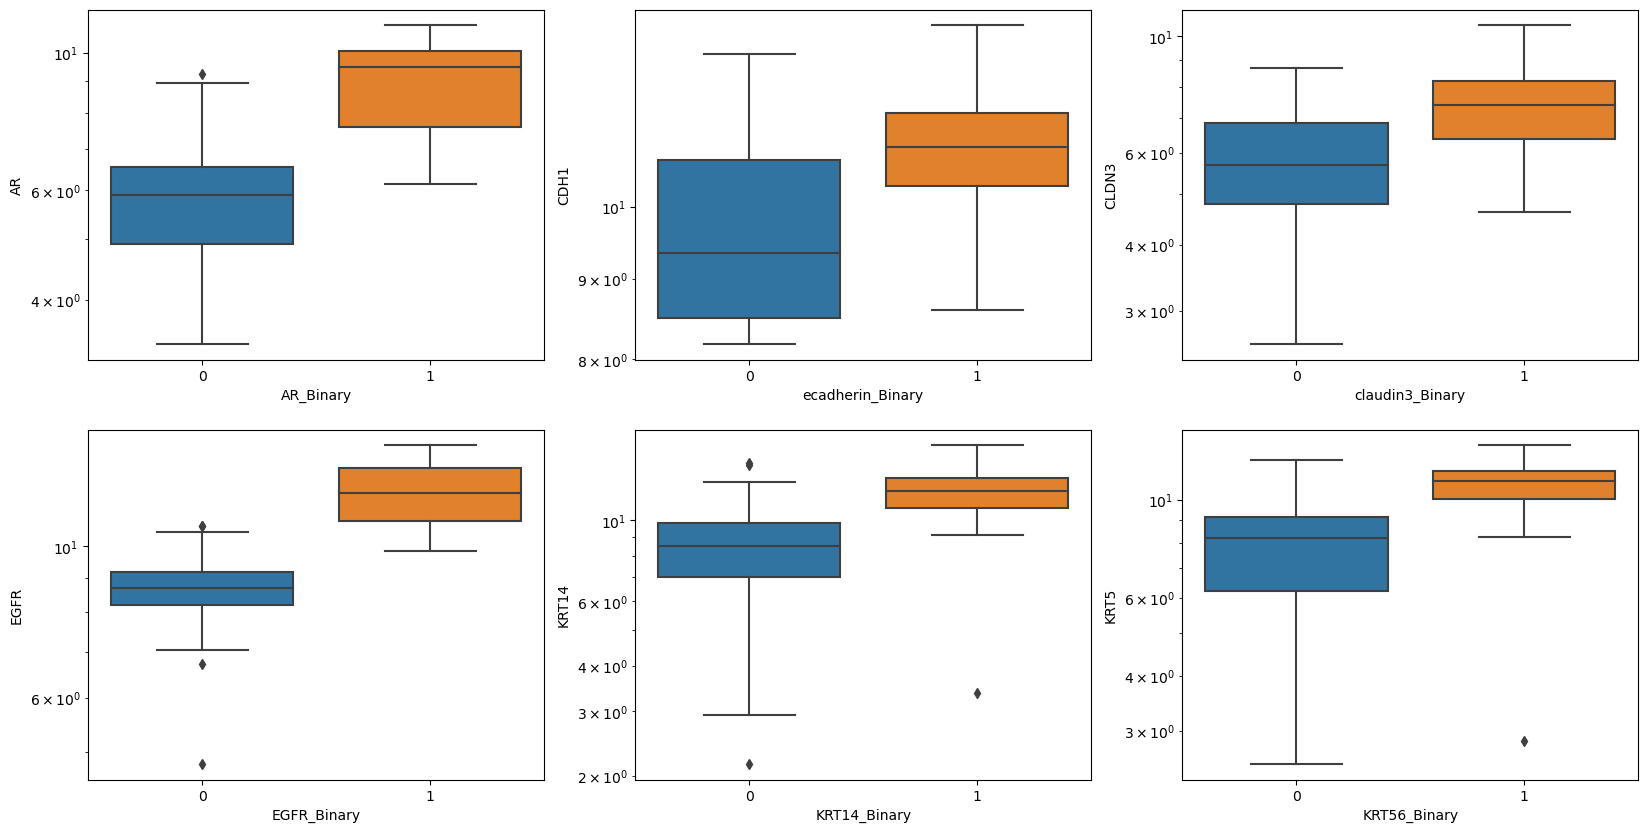

In [79]:
# Create a boxplot of different variables side by side
plt.figure(figsize=(20, 10))
continues_list = ['AR', 'CDH1', 'CLDN3', 'EGFR', 'KRT14', 'KRT5']
binary_list = TMA_binary.columns.tolist()
binary_list.remove('ID')

for i, c in enumerate(continues_list, 1):
    plt.subplot(2, 3, i)
    g = sns.boxplot(x=binary_list[i - 1], y=c, data=IHC_binary_annotation_nanoString_related_genes)
    g.set(yscale="log")
plt.savefig('plots/1.pdf', format='pdf')
#plt.savefig('plots/binary_IHC_nanoString.png')


In [80]:
IHC_PAM50 = merge_two_datasets(nanoString_PAM50, TMA_averaged_scores)
print(
    f"\nThe number of samples with IHC scores and PAM50 data: {len(IHC_PAM50):.0f}")


The number of samples with IHC scores and PAM50 data: 83


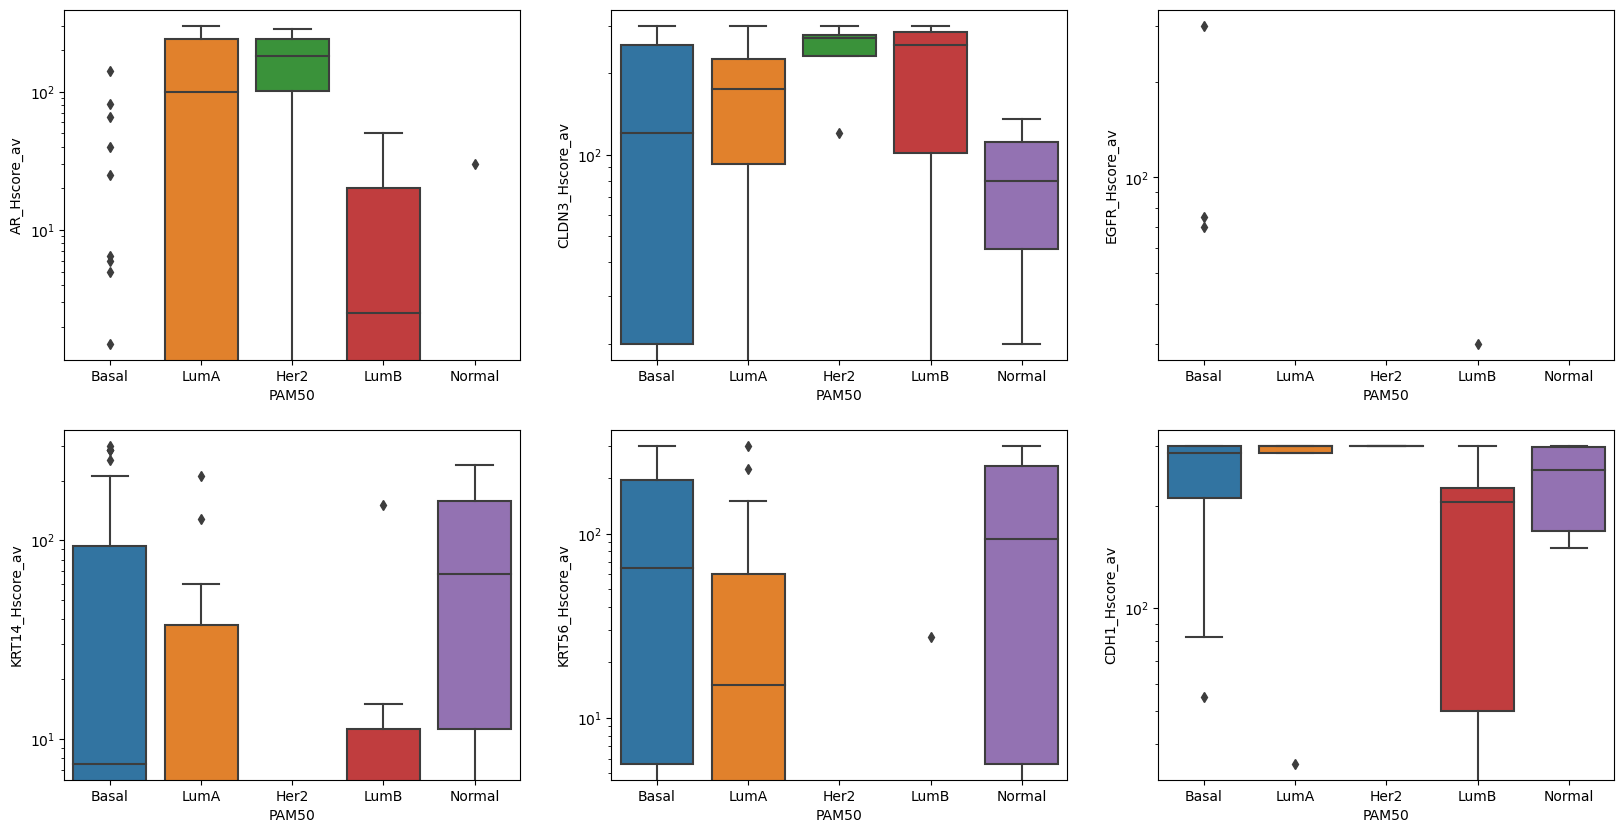

In [82]:
plt.figure(figsize=(20, 10))
continues_list = IHC_PAM50.columns.tolist()

continues_list.remove('PAM50')
continues_list.remove('ID')

for i, c in enumerate(continues_list, 1):
    plt.subplot(2, 3, i)
    g = sns.boxplot(x='PAM50', y=c, data=IHC_PAM50)
    g.set(yscale="log")


In [84]:
# perform the merge between PAM50 scores and our digital scores
PAM50_digital_scores = merge_two_datasets(nanoString_PAM50, digital_scores)

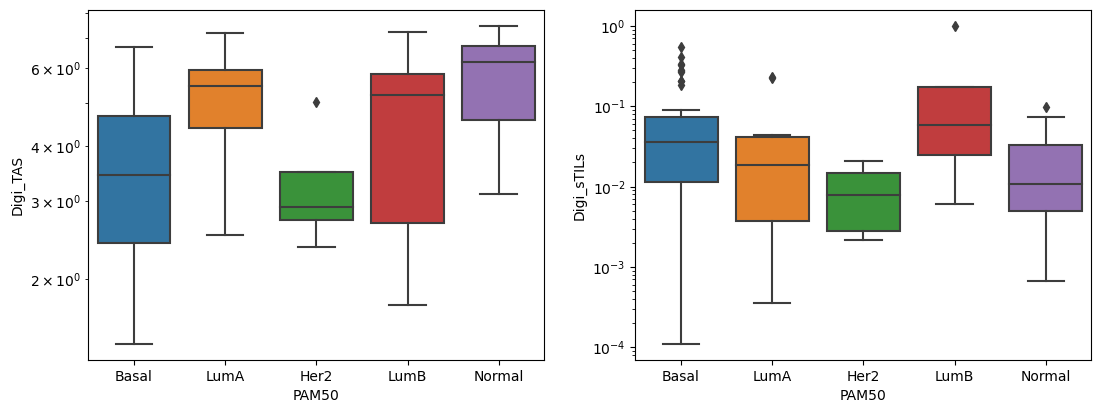

In [91]:
plt.figure(figsize=(20, 10))
column_lists = ['Digi_TAS', 'Digi_sTILs']
for i, c in enumerate(column_lists, 1):
    plt.subplot(2, 3, i)
    g = sns.boxplot(x='PAM50', y=c,
                    data=PAM50_digital_scores)
    g.set(yscale="log")

plt.savefig('plots/pam501_DigiScore.png')
plt.savefig('plots/2.pdf', format='pdf')
plt.show()


In [58]:
IHC_digital_scores = merge_two_datasets(TMA_averaged_scores, digital_scores)
print(f"The number of sampels:{len(IHC_digital_scores)}")

The number of sampels:199


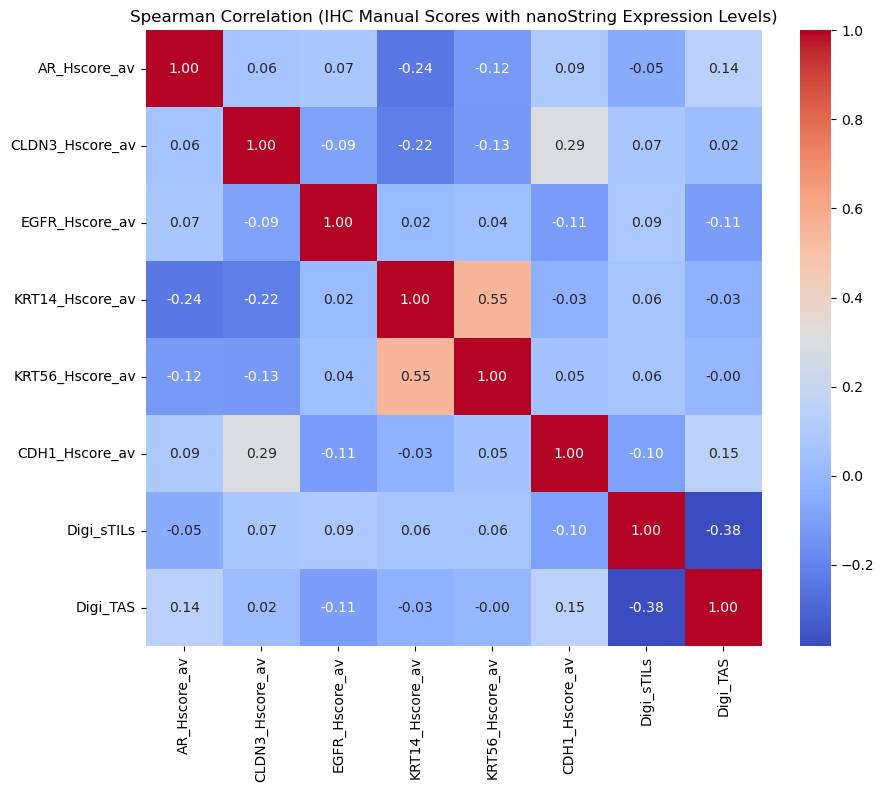

In [59]:
# Calculate Spearman correlation matrix
corr_matrix = IHC_digital_scores.drop(['ID'], axis=1).corr(method='spearman')

# Create a heatmap with only the lower triangular part
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)  #, mask=mask)
plt.title('Spearman Correlation (IHC Manual Scores with nanoString Expression Levels)')
plt.savefig('plots/IHC_nanoString_Spearman.png')
plt.show()

In [23]:
#perfrom the merge between our digital scores and nanoString data
digi_scores_nanoString_gene_expression_levels = merge_two_datasets(nanoString_data, digital_scores)

In [24]:
# List of genes
gene_lists = digi_scores_nanoString_gene_expression_levels.columns.tolist()
gene_lists.remove('ID')
gene_lists.remove('Digi_sTILs')
gene_lists.remove('Digi_TAS')

In [25]:
# apply Spearman correlation with Bonferroni correction

## calculate correlation for Digi-sTILs scores
p_values = []
r_values = []
features = []

digital_scores_column = digi_scores_nanoString_gene_expression_levels['Digi_sTILs']
for gene in gene_lists:
    # Replace this line with actual gene expression data retrieval
    gene_data = digi_scores_nanoString_gene_expression_levels[gene]

    # Calculate Pearson correlation coefficient and p-value
    r, p = spearmanr(gene_data, digital_scores_column)

    # Append results to list_s
    r_values.append(r)
    p_values.append(p)
    features.append(gene)

# Correct p-values using Bonferroni correction
n_tests = len(gene_lists)
corrected_p_values = multipletests(p_values, method='bonferroni')[1]

# Create a pandas DataFrame to display the results as a table
result_df = pd.DataFrame({
    'Gene': features,
    'Spearman Correlation (r)': r_values,
    'Uncorrected p-value': p_values,
    'Bonferroni Corrected p-value': corrected_p_values
})

# Display the table
result_df.to_csv('correlation_nanoString_Digi_sTILs.csv')

In [26]:
## calculate correlation for Digi-TAS scores
p_values = []
r_values = []
features = []

digital_scores_column = digi_scores_nanoString_gene_expression_levels['Digi_TAS']
for gene in gene_lists:
    # Replace this line with actual gene expression data retrieval
    gene_data = digi_scores_nanoString_gene_expression_levels[gene]

    # Calculate Pearson correlation coefficient and p-value
    r, p = spearmanr(gene_data, digital_scores_column)

    # Append results to list_s
    r_values.append(r)
    p_values.append(p)
    features.append(gene)

# Correct p-values using Bonferroni correction
n_tests = len(gene_lists)
corrected_p_values = multipletests(p_values, method='bonferroni')[1]

# Create a pandas DataFrame to display the results as a table
result_df = pd.DataFrame({
    'Gene': features,
    'Spearman Correlation (r)': r_values,
    'Uncorrected p-value': p_values,
    'Bonferroni Corrected p-value': corrected_p_values
})

# Display the table
result_df.to_csv('correlation_nanoString_Digi_TAS.csv')

To perform the survival analysis with different patient data using bootstrapping with overall survival and disease specific survival

In [27]:
# using clinical with DSS, OS and k-folds
dataset = merge_two_datasets(survival_outcomes, clinical_info)

event_col = 'OS'
dataset = dataset.loc[:,
          ['time', event_col, 'age', 'Axillary nodes Flag', 'Sentinel nodes Flag', 'tumour_size']]

dataset = dataset.rename(columns={event_col: 'event'})
#check for nans and drop the row that contains it
df = dataset.dropna()

# Look at the categorical and numerical variables
summary_categorical = []
for column in df.columns:
    if df[column].dtype == object:
        summary_categorical.append(column)
        print(df[column].value_counts())
        print(f"----------------------------------")

summary_numerical = []
for column in df.columns:
    if df[column].dtype != object:
        print(f"{column} : Minimum: {min((df[column].unique()))}, Maximum: {max((df[column].unique()))} ")
        summary_numerical.append(column)
        print(f"----------------------------------")

# Convert all string categorical variables into integer labels
encoder = LabelEncoder()
# Convert string categorical variables into integer labels
categorical_columns = df.select_dtypes(include=['object'])
for column in categorical_columns.columns:
    df[column] = encoder.fit_transform(df[column])

print(f"The number of sampels:{len(df)}")

survival_with_k_folds(df, print_results=True)

time : Minimum: 0, Maximum: 273 
----------------------------------
event : Minimum: 0, Maximum: 1 
----------------------------------
age : Minimum: 26, Maximum: 93 
----------------------------------
Axillary nodes Flag : Minimum: 0, Maximum: 1 
----------------------------------
Sentinel nodes Flag : Minimum: 0, Maximum: 1 
----------------------------------
tumour_size : Minimum: 2.0, Maximum: 150.0 
----------------------------------
The number of sampels:358

Mean C-index across all folds: 0.767

STD C-index across all folds: 0.088


(0.7666087118920195, 0.08820510733853945)

In [28]:
# using Digi-TAS and Digi-sTILs with DSS, OS and k-folds
dataset = merge_two_datasets(survival_outcomes, digital_scores)

event_col = 'DSS'
dataset = dataset.loc[:,
          ['time', event_col, 'Digi_sTILs', 'Digi_TAS']]

dataset = dataset.rename(columns={event_col: 'event'})
#check for nans and drop the row that contains it
df = dataset.dropna()

print(f"The number of sampels:{len(df)}")

survival_with_k_folds(df)

The number of sampels:319


(0.6543233383842758, 0.1252310363146358)

In [29]:
# using IHC markers with DSS, OS, and k-folds
dataset = merge_two_datasets(survival_outcomes, TMA_averaged_scores)
event_col = 'OS'
dataset = dataset.loc[:,
          ['time', event_col, 'AR_Hscore_av', 'CLDN3_Hscore_av', 'KRT14_Hscore_av', 'KRT56_Hscore_av',
           'CDH1_Hscore_av']]

dataset = dataset.rename(columns={event_col: 'event'})
#check for nans and drop the row that contains it
df = dataset.dropna()

print(f"The number of sampels:{len(df)}")

survival_with_k_folds(df, print_results=True, num_folds=5)

The number of sampels:219

Mean C-index across all folds: 0.549

STD C-index across all folds: 0.059


(0.5485537792036235, 0.05904969162438019)

In [30]:
dataset = merge_two_datasets(survival_outcomes, nanoString_z_score_pca_scree)

event_col = 'OS'
temp = nanoString_z_score_pca_scree.drop(['ID'], axis=1)
selected_cols = temp.columns.tolist()
selected_cols.extend(['time', event_col])

dataset = dataset.loc[:, selected_cols]

dataset = dataset.rename(columns={event_col: 'event'})
#check for nans and drop the row that contains it
df = dataset.dropna()

print(f"The number of samples: {len(df)}")

survival_with_k_folds(df, print_results=True, penalizer=0.0, num_folds=3)

The number of samples: 96

Mean C-index across all folds: 0.482

STD C-index across all folds: 0.104


(0.4817110649872474, 0.10434343189950478)

In [31]:
#All features
dataset_nano = merge_two_datasets(survival_outcomes, nanoString_z_score_pca_scree)

dataset_nano_TMA = merge_two_datasets(dataset_nano, TMA_averaged_scores)

dataset_nano_TMA_digi = merge_two_datasets(dataset_nano_TMA, digital_scores)

dataset_nano_TMA_digi_clinical = merge_two_datasets(dataset_nano_TMA_digi, clinical_info)

dataset_nano_TMA_digi_clinical_binary = merge_two_datasets(TMA_binary, dataset_nano_TMA_digi_clinical)

# Convert all string categorical variables into integer labels
encoder = LabelEncoder()
# Convert string categorical variables into integer labels
categorical_columns = dataset_nano_TMA_digi_clinical.select_dtypes(include=['object'])
for column in categorical_columns.columns:
    if not (column == 'ID'):
        dataset_nano_TMA_digi_clinical[column] = encoder.fit_transform(dataset_nano_TMA_digi_clinical[column])

event_col = 'DSS'

selected_cols = ['time', event_col, 'PCA_1', 'PCA_2',
                 'PCA_3', 'PCA_4', 'PCA_5', 'Axillary nodes Flag'
    , 'Sentinel nodes Flag', 'tumour_size', 'age', 'Digi_sTILs', 'Digi_TAS', 'AR_Hscore_av', 'CLDN3_Hscore_av',
                 'KRT14_Hscore_av', 'KRT56_Hscore_av', 'CDH1_Hscore_av']

dataset = dataset_nano_TMA_digi_clinical.loc[:, selected_cols]

dataset = dataset.rename(columns={event_col: 'event'})

dataset = dataset.dropna()

print(f"The number of samples: {len(dataset)}")

survival_with_k_folds(dataset, penalizer=0.0, num_folds=3)

The number of samples: 75


/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/Users/rawan/.conda/envs/Tissue_Image_Analysis/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines 

(0.48351423800894733, 0.10589460814611572)

Perform survival analysis using the gene sets from the associated terms using nanoString provided pathways

In [48]:
pathways_cols = nanoString_pathways.columns.tolist()
pathways_cols.remove('gene_symbol')
pathways_cols.remove('entrez_ID')

for item in pathways_cols:
    gene_lists = ['ID']
    genes_PCA = []
    print(item)
    for index, row in nanoString_pathways.iterrows():
        value = row[item]
        if value > 0:
            gene_lists.append(row['gene_symbol'])
            genes_PCA.append(row['gene_symbol'])

    nanoString_data_temp = nanoString_data_zscore.loc[:, gene_lists]

    pathway_clinical_genes = merge_two_datasets(nanoString_data_temp, survival_outcomes)

    event_col = 'OS'
    pathway_clinical_genes = pathway_clinical_genes.rename(columns={event_col: 'event'})

    dataset_PCA = pathway_clinical_genes.loc[:, genes_PCA]

    pca = PCA(n_components=2)
    PCA_cols = []
    for i in range(0, 2):
        PCA_cols.append('PCA_' + str(i + 1))

    dataset = pd.DataFrame(data=pca.fit_transform(dataset_PCA), columns=PCA_cols)

    dataset = [pathway_clinical_genes.loc[:, ['time', 'event']], dataset]

    dataset = pd.concat(dataset, axis=1, join='inner')

    survival_with_k_folds(dataset, print_results=True, num_folds=3)


Adhesion_and_Migration

Mean C-index across all folds: 0.481

STD C-index across all folds: 0.101
Angiogenesis

Mean C-index across all folds: 0.504

STD C-index across all folds: 0.137
Antigen_Presentation

Mean C-index across all folds: 0.428

STD C-index across all folds: 0.087
Apoptosis

Mean C-index across all folds: 0.374

STD C-index across all folds: 0.109
Cytokine_and_Chemokine_Signaling

Mean C-index across all folds: 0.602

STD C-index across all folds: 0.099
DNA_Damage_Repair

Mean C-index across all folds: 0.506

STD C-index across all folds: 0.111
EMT

Mean C-index across all folds: 0.537

STD C-index across all folds: 0.084
ER_Signaling

Mean C-index across all folds: 0.400

STD C-index across all folds: 0.074
Epigenetic_Regulation

Mean C-index across all folds: 0.505

STD C-index across all folds: 0.088
Hedgehog

Mean C-index across all folds: 0.482

STD C-index across all folds: 0.127
Immune_Infiltration

Mean C-index across all folds: 0.525

STD C-index across all fo

In [33]:

# terms_value = []
# genes_list = []
# raw_c_indices = []
# raw_stds = []
# z_score_c_indices = []
# z_score_stds = []
#
# nanoString_survival_temp = merge_two_datasets(nanoString_data, survival_outcomes)
# nanoString_zscore_survival_temp = merge_two_datasets(nanoString_data_zscore, survival_outcomes)
#
# file_name = 'OS_GSEA_genes_all_pathways_c_indices.csv'
# event_col = 'OS'
#
# for index, row in GSEA_pathways_all.iterrows():
#     try:
#         genes = ['time', event_col]
#         term_gene_list = row['Genes'].split(';')
#
#         for item in term_gene_list:
#             genes.append(item)
#
#         nanoString_survival_temp_gene_lists = nanoString_survival_temp.loc[:, genes]
#
#         nanoString_zscore_survival_temp_gene_lists = nanoString_zscore_survival_temp.loc[:, genes]
#
#         nanoString_survival_temp_gene_lists = nanoString_survival_temp_gene_lists.rename(columns={event_col: 'event'})
#
#         nanoString_zscore_survival_temp_gene_lists = nanoString_zscore_survival_temp_gene_lists.rename(
#             columns={event_col: 'event'})
#
#         print(nanoString_survival_temp_gene_lists)
#         print(nanoString_zscore_survival_temp_gene_lists)
#
#         cof, std = survival_with_k_folds(nanoString_survival_temp_gene_lists, num_folds=3, penalizer=0.01)
#         cof_, std_ = survival_with_k_folds(nanoString_zscore_survival_temp_gene_lists, num_folds=3, penalizer=0.01)
#
#         terms_value.append(row['Term'])
#         genes_list.append(row['Genes'])
#         raw_c_indices.append(cof)
#         raw_stds.append(std)
#         z_score_c_indices.append(cof_)
#         z_score_stds.append(std_)
#
#         result_df = pd.DataFrame({
#             'Terms': terms_value,
#             'Genes': genes_list,
#             'Raw c indices': raw_c_indices,
#             'Raw std': raw_stds,
#             'Z score c indices': z_score_c_indices,
#             'Z score std': z_score_stds
#
#         })
#
#         result_df.to_csv(file_name)
#
#     except:
#         pass


In [61]:
terms_value = []
genes_list = []
raw_c_indices = []
z_score_c_indices = []
raw_stds = []
z_score_stds = []

pca = PCA(n_components=3)
PCA_cols = []
for i in range(0, 3):
    PCA_cols.append('PCA_' + str(i + 1))

nanoString_survival_temp = merge_two_datasets(nanoString_data, survival_outcomes)
nanoString_zscore_survival_temp = merge_two_datasets(nanoString_data_zscore, survival_outcomes)

event_col = 'DSS'
file_name = 'DSS_pca_GSEA_genes_all_pathways_c_indices.csv'

for index, row in GSEA_pathways_all.iterrows():
    try:
        genes = ['time', event_col]
        genes_pca = []
        term_gene_list = row['Genes'].split(';')

        for item in term_gene_list:
            genes.append(item)
            genes_pca.append(item)

        nanoString_temp_gene_lists = nanoString_survival_temp.loc[:, genes]
        nanoString_zscore_survival_temp_gene_lists = nanoString_zscore_survival_temp.loc[:, genes]

        nanoString_temp_gene_lists = nanoString_temp_gene_lists.rename(columns={event_col: 'event'})
        nanoString_zscore_survival_temp_gene_lists = nanoString_zscore_survival_temp_gene_lists.rename(
            columns={event_col: 'event'})

        nanoString_temp_gene_lists_pca = pd.DataFrame(
            data=pca.fit_transform(nanoString_temp_gene_lists.loc[:, genes_pca]),
            columns=PCA_cols)

        nanoString_temp_gene_lists = [nanoString_temp_gene_lists.loc[:, ['time', 'event']],
                                      nanoString_temp_gene_lists_pca]

        nanoString_temp_gene_lists = pd.concat(nanoString_temp_gene_lists, axis=1, join='inner')

        nanoString_zscore_survival_temp_gene_lists_pca = pd.DataFrame(
            data=pca.fit_transform(nanoString_zscore_survival_temp_gene_lists.loc[:, genes_pca]), columns=PCA_cols)

        nanoString_zscore_survival_temp_gene_lists = [
            nanoString_zscore_survival_temp_gene_lists.loc[:, ['time', 'event']],
            nanoString_zscore_survival_temp_gene_lists_pca]

        nanoString_zscore_survival_temp_gene_lists = pd.concat(nanoString_zscore_survival_temp_gene_lists, axis=1,
                                                               join='inner')

        cof, std = survival_with_k_folds(nanoString_temp_gene_lists, num_folds=3)
        cof_, std_ = survival_with_k_folds(nanoString_zscore_survival_temp_gene_lists, num_folds=3)

        terms_value.append(row['Term'])
        genes_list.append(row['Genes'])
        raw_c_indices.append(cof)
        raw_stds.append(std)
        z_score_c_indices.append(cof_)
        z_score_stds.append(std_)

        result_df = pd.DataFrame({
            'Terms': terms_value,
            'Genes': genes_list,
            'Raw c indices': raw_c_indices,
            'Raw std': raw_stds,
            'Z score c indices': z_score_c_indices,
            'Z score std': z_score_stds
        })

        result_df.to_csv(file_name)
    except:
        pass